In [16]:
import os
import json
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

In [17]:
bags_folder = '../data/char_bags'
tropes_folder = '../data/tropes/tvtropes.clusters.txt'
model = SentenceTransformer('all-mpnet-base-v2') #Current embedding model for now, could be changed

In [18]:
def load_character_bags(json_folder):
    character_bags = {}
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename)) as f:
                data = json.load(f)
                for character in data:
                    name = character['name']
                    bag_words = " ".join([f"{pair[0]} {pair[1]}" for pair in character['bag']])
                    character_bags[name] = bag_words
    return character_bags

c = load_character_bags(bags_folder)

In [19]:
def load_tropes(tropes_file):
    trope_dict = {}
    with open(tropes_file) as f:
        for line in f:
            trope, char_data = line.split("\t")
            char_info = json.loads(char_data)
            name = char_info['char']
            trope_dict[name] = trope
    return trope_dict

t = load_tropes(tropes_folder)

In [20]:
def get_overlapping_characters(character_bags, trope_dict):
    common_characters = set(character_bags.keys()).intersection(trope_dict.keys())
    filtered_bags = {name: character_bags[name] for name in common_characters}
    filtered_tropes = {name: trope_dict[name] for name in common_characters}
    return filtered_bags, filtered_tropes

c, t = get_overlapping_characters(c, t)

In [21]:
def perform_clustering(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels

In [22]:
def get_embeddings(character_bags):
    character_names = list(character_bags.keys())
    bag_texts = list(character_bags.values())
    embeddings = model.encode(bag_texts)
    return embeddings, character_names

class ClusterLoss(nn.Module):
    def __init__(self, gt, margin=1.0):
        super(ClusterLoss, self).__init__()
        self.margin = margin
        label_mapping = {
            'master_swordsman': 0,
            'corrupt_corporate_executive': 1,
            'psycho_for_hire': 2,
            'brainless_beauty': 3
        }
        self.gt = torch.tensor([label_mapping[trope] for _, trope in gt.items()], dtype=torch.long)

    def forward(self, embeddings):
        num_samples = embeddings.size(0)
        loss = 0.0
        
        for i in range(num_samples):
            for j in range(i + 1, num_samples):
                if self.gt[i] == self.gt[j]:
                    loss += F.mse_loss(embeddings[i], embeddings[j])
                else:
                    loss += torch.max(torch.tensor(0.0), self.margin - torch.dist(embeddings[i], embeddings[j]))

        loss = loss / (num_samples * (num_samples - 1) / 2)
        
        return loss

def fine_tune_embeddings(character_bags, character_tropes, num_clusters=4, epochs=1000, lr=1e-4):
    embeddings, character_names = get_embeddings(character_bags)
    embeddings_tensor = torch.tensor(embeddings, requires_grad=True)

    optimizer = Adam([embeddings_tensor], lr=lr)
    criterion = ClusterLoss(character_tropes)

    for epoch in range(epochs):
        optimizer.zero_grad()

        cluster_labels = perform_clustering(embeddings_tensor.detach().numpy(), num_clusters)

        loss = criterion(embeddings_tensor)
        
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

    return embeddings_tensor.detach().numpy()  

num_clusters = len(set(t.values()))

final_embeddings = fine_tune_embeddings(c, t, num_clusters=num_clusters)

final_labels = perform_clustering(final_embeddings, num_clusters)

cluster_dict = {i: [] for i in range(num_clusters)}

print("Prediction:")
for name, label in zip(list(c.keys()), final_labels):
    cluster_dict[label].append(name)
for cluster, characters in cluster_dict.items():
    print(f"Cluster {cluster}: {', '.join(characters)}")
    
print("\nGroundtruth:")
grouped_by_trope = {}
for name, trope in t.items():
    if trope not in grouped_by_trope:
        grouped_by_trope[trope] = []
    grouped_by_trope[trope].append(name)
for trope, characters in grouped_by_trope.items():
    print(f"{trope}: {', '.join(characters)}")

Epoch 0/1000, Loss: 0.23955245316028595
Epoch 100/1000, Loss: 0.022182989865541458
Epoch 200/1000, Loss: 0.00029865355463698506
Epoch 300/1000, Loss: 0.0002978781994897872
Epoch 400/1000, Loss: 0.0002969230990856886
Epoch 500/1000, Loss: 0.0002958164841402322
Epoch 600/1000, Loss: 0.00029456691117957234
Epoch 700/1000, Loss: 0.00029317985172383487
Epoch 800/1000, Loss: 0.0002916590601671487
Epoch 900/1000, Loss: 0.0002900069812312722
Prediction:
Cluster 0: Frank, Buffy Summers
Cluster 1: Qui-Gon Jinn, Obi-Wan Kenobi, Inigo Montoya
Cluster 2: Henry F. Potter, Darth Vader, Noah Cross
Cluster 3: Waingro, Major Arnold Toht

Groundtruth:
corrupt_corporate_executive: Henry F. Potter, Noah Cross
master_swordsman: Darth Vader, Qui-Gon Jinn, Obi-Wan Kenobi, Inigo Montoya
psycho_for_hire: Waingro, Frank, Major Arnold Toht
brainless_beauty: Buffy Summers


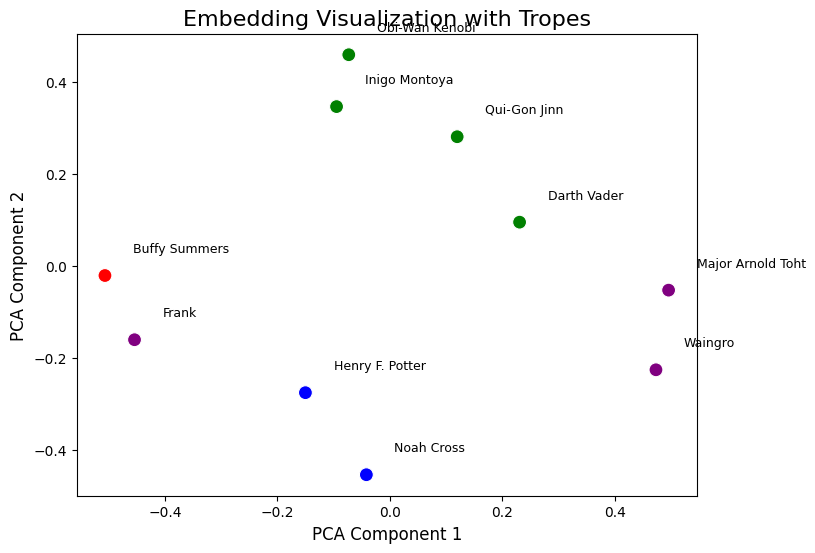

In [23]:
def plot_embeddings(embeddings, labels, tropes, character_names):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    trope_colors = {
        "brainless_beauty": 'red',
        "corrupt_corporate_executive": 'blue',
        "master_swordsman": 'green',
        "psycho_for_hire": 'purple'
    }

    embedding_labels = [tropes[name] for name in character_names]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=embedding_labels, 
                    palette=trope_colors, legend=None, s=100, marker='o')

    for i, name in enumerate(character_names):
        plt.text(embeddings_2d[i, 0] + 0.05, embeddings_2d[i, 1] + 0.05, name, fontsize=9)

    plt.title("Embedding Visualization with Tropes", fontsize=16)
    plt.xlabel("PCA Component 1", fontsize=12)
    plt.ylabel("PCA Component 2", fontsize=12)
    plt.show()

plot_embeddings(final_embeddings, final_labels, t, list(c.keys()))